# Overview
This is just a simple first attempt at a model using VGG16 as a basis and attempting to do classification directly on the mammography using low-resolution images (192x192)

This can be massively improved with 
* high-resolution images
* better data sampling
* ensuring there is no leaking between training and validation sets, ```sample(replace = True)``` is real dangerous
* pretrained models
* attention/related techniques to focus on areas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

## Preprocessing
Turn the HDF5 into a data-frame and a folder full of TIFF files

In [3]:
import numpy as np
import pandas as pd
import os
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_tree
from xgboost import plot_importance
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # Inception
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")

In [22]:
w , h= 64,64
final_class = 5 # 1 for meningioma, 2 for glioma, 3 for pituitary tumor
w,h,final_class

(64, 64, 5)

In [5]:
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
    new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
    for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
        os.makedirs(dest1);
        os.makedirs(dest2);
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (w, h));
                img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);
    # Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (w, h));
                img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);

# Source Location for Dataset
src = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed';
# Destination Location for Dataset
dest = './CervicalCancer';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);



In [7]:
import os
import numpy as np
import cv2
from tqdm import tqdm




# Initialize lists to store data and labels
X = []
Y = []

import os
import cv2
import numpy as np

def LoadDataset(dataset_path, classes, img_size=(256, 256)):
    X, Y = [], []
    class_map = {cls: idx for idx, cls in enumerate(classes)}
    
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls, 'COMPLETE')  # Load from COMPLETE folder
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found.")
            continue
        
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(file_path)
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                X.append(img)
                Y.append(class_map[cls])
    
    X = np.array(X, dtype=np.float32) / 255.0  # Normalize images
    Y = np.array(Y, dtype=np.int32)  # Convert labels to NumPy array
    
    print(f"Dataset Loaded: X shape = {X.shape}, Y shape = {Y.shape}")
    return X, Y

# Dataset Path
dataset_path = "./CervicalCancer"
# Image Classes
classes = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

# Load Dataset
X, Y = LoadDataset(dataset_path, classes)


# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Function to preprocess the images
def preprocess_image(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filtering
    filtered_image = cv2.bilateralFilter(gray_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Normalize the image to range [0, 1]
    normalized_image = filtered_image / 255.0
    
    # Reshape the image to add a channel dimension
    normalized_image = normalized_image.reshape(normalized_image.shape[0], normalized_image.shape[1], 1)

    return normalized_image

# Preprocess the images
X_preprocessed = []
for i in tqdm(range(X.shape[0]), desc="Preprocessing images"):
    processed_image = preprocess_image(X[i])
    X_preprocessed.append(X[i])

# Convert the list to a numpy array
X_preprocessed = np.array(X_preprocessed)

# Save the preprocessed data and labels as .npy files
np.save('Images.npy', X_preprocessed)
np.save('Labels.npy', Y)

# Print the shapes of the saved arrays
print(f"Processed image dataset shape: {X_preprocessed.shape}")
print(f"Labels shape: {Y.shape}")

Dataset Loaded: X shape = (966, 256, 256, 3), Y shape = (966,)


Preprocessing images: 100%|██████████| 966/966 [00:04<00:00, 232.84it/s]


Processed image dataset shape: (966, 256, 256, 3)
Labels shape: (966,)


In [8]:
X = X_preprocessed 

In [9]:
y = Y

In [10]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
from sklearn.preprocessing import OneHotEncoder
Y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y = enc.transform(Y).toarray()
Y.shape

(966, 5)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=42, test_size=0.2)
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(772, 256, 256, 3)
Test data     :(194, 256, 256, 3)
Train Output  :(772, 5)
Test Output   :(194, 5)


# Attention Model
The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP.
It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model
import keras.backend as K

# Adjusted input shape for grayscale images (1 channel)
input_shape = (256, 256, 3)  # Single channel (grayscale)
in_lay = Input(shape=input_shape)

# Load VGG16 with input shape 64x64, excluding the top fully connected layers
base_pretrained_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Replicate the single channel to 3 channels (for VGG16 compatibility)
# x = Conv2D(3, (1, 1), padding='same')(in_lay)

# Pass the adjusted input through VGG16
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)

# Apply Batch Normalization
bn_features = BatchNormalization()(pt_features)

# Attention mechanism: Conv layers to produce an attention mask
attn_layer = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(bn_features)
attn_layer = Conv2D(16, kernel_size=(1, 1), padding='same', activation='relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size=(1, 1), padding='valid', activation='sigmoid')(attn_layer)

# Apply the attention mask to the feature map
up_c2 = Conv2D(bn_features.shape[-1], kernel_size=(1, 1), padding='same', activation='linear', use_bias=False)(attn_layer)
# Mask the features with the attention output
mask_features = multiply([up_c2, bn_features])

# Global average pooling on masked features and attention mask
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# Rescale GAP to account for missing values from the attention model
gap = Lambda(lambda x: x[0] / (x[1] + K.epsilon()), name='RescaleGAP')([gap_features, gap_mask])

# Add dropout and fully connected layers
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation='elu')(gap_dr))

# Output layer for classification
out_layer = Dense(final_class, activation='softmax')(dr_steps)

# Create the model
mammo_model = Model(inputs=[in_lay], outputs=[out_layer])

# Compile the model
mammo_model.compile(optimizer='adam', loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

# Display the model summary
mammo_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 8, 8, 512)      │     14,714,688 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 8, 8, 512)      │          2,048 │ vgg16[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 8, 64)       │         32,832 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 8, 8, 16)       │          1,040 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 8, 8, 1)        │             17 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 8, 8, 512)      │            512 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 8, 8, 512)      │              0 │ conv2d_23[0][0],       │
│                           │                        │                │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ multiply_1[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1)              │              0 │ conv2d_22[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RescaleGAP (Lambda)       │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ RescaleGAP[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         65,664 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5)              │            645 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,817,446 (56.52 MB)

 Trainable params: 101,734 (397.40 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

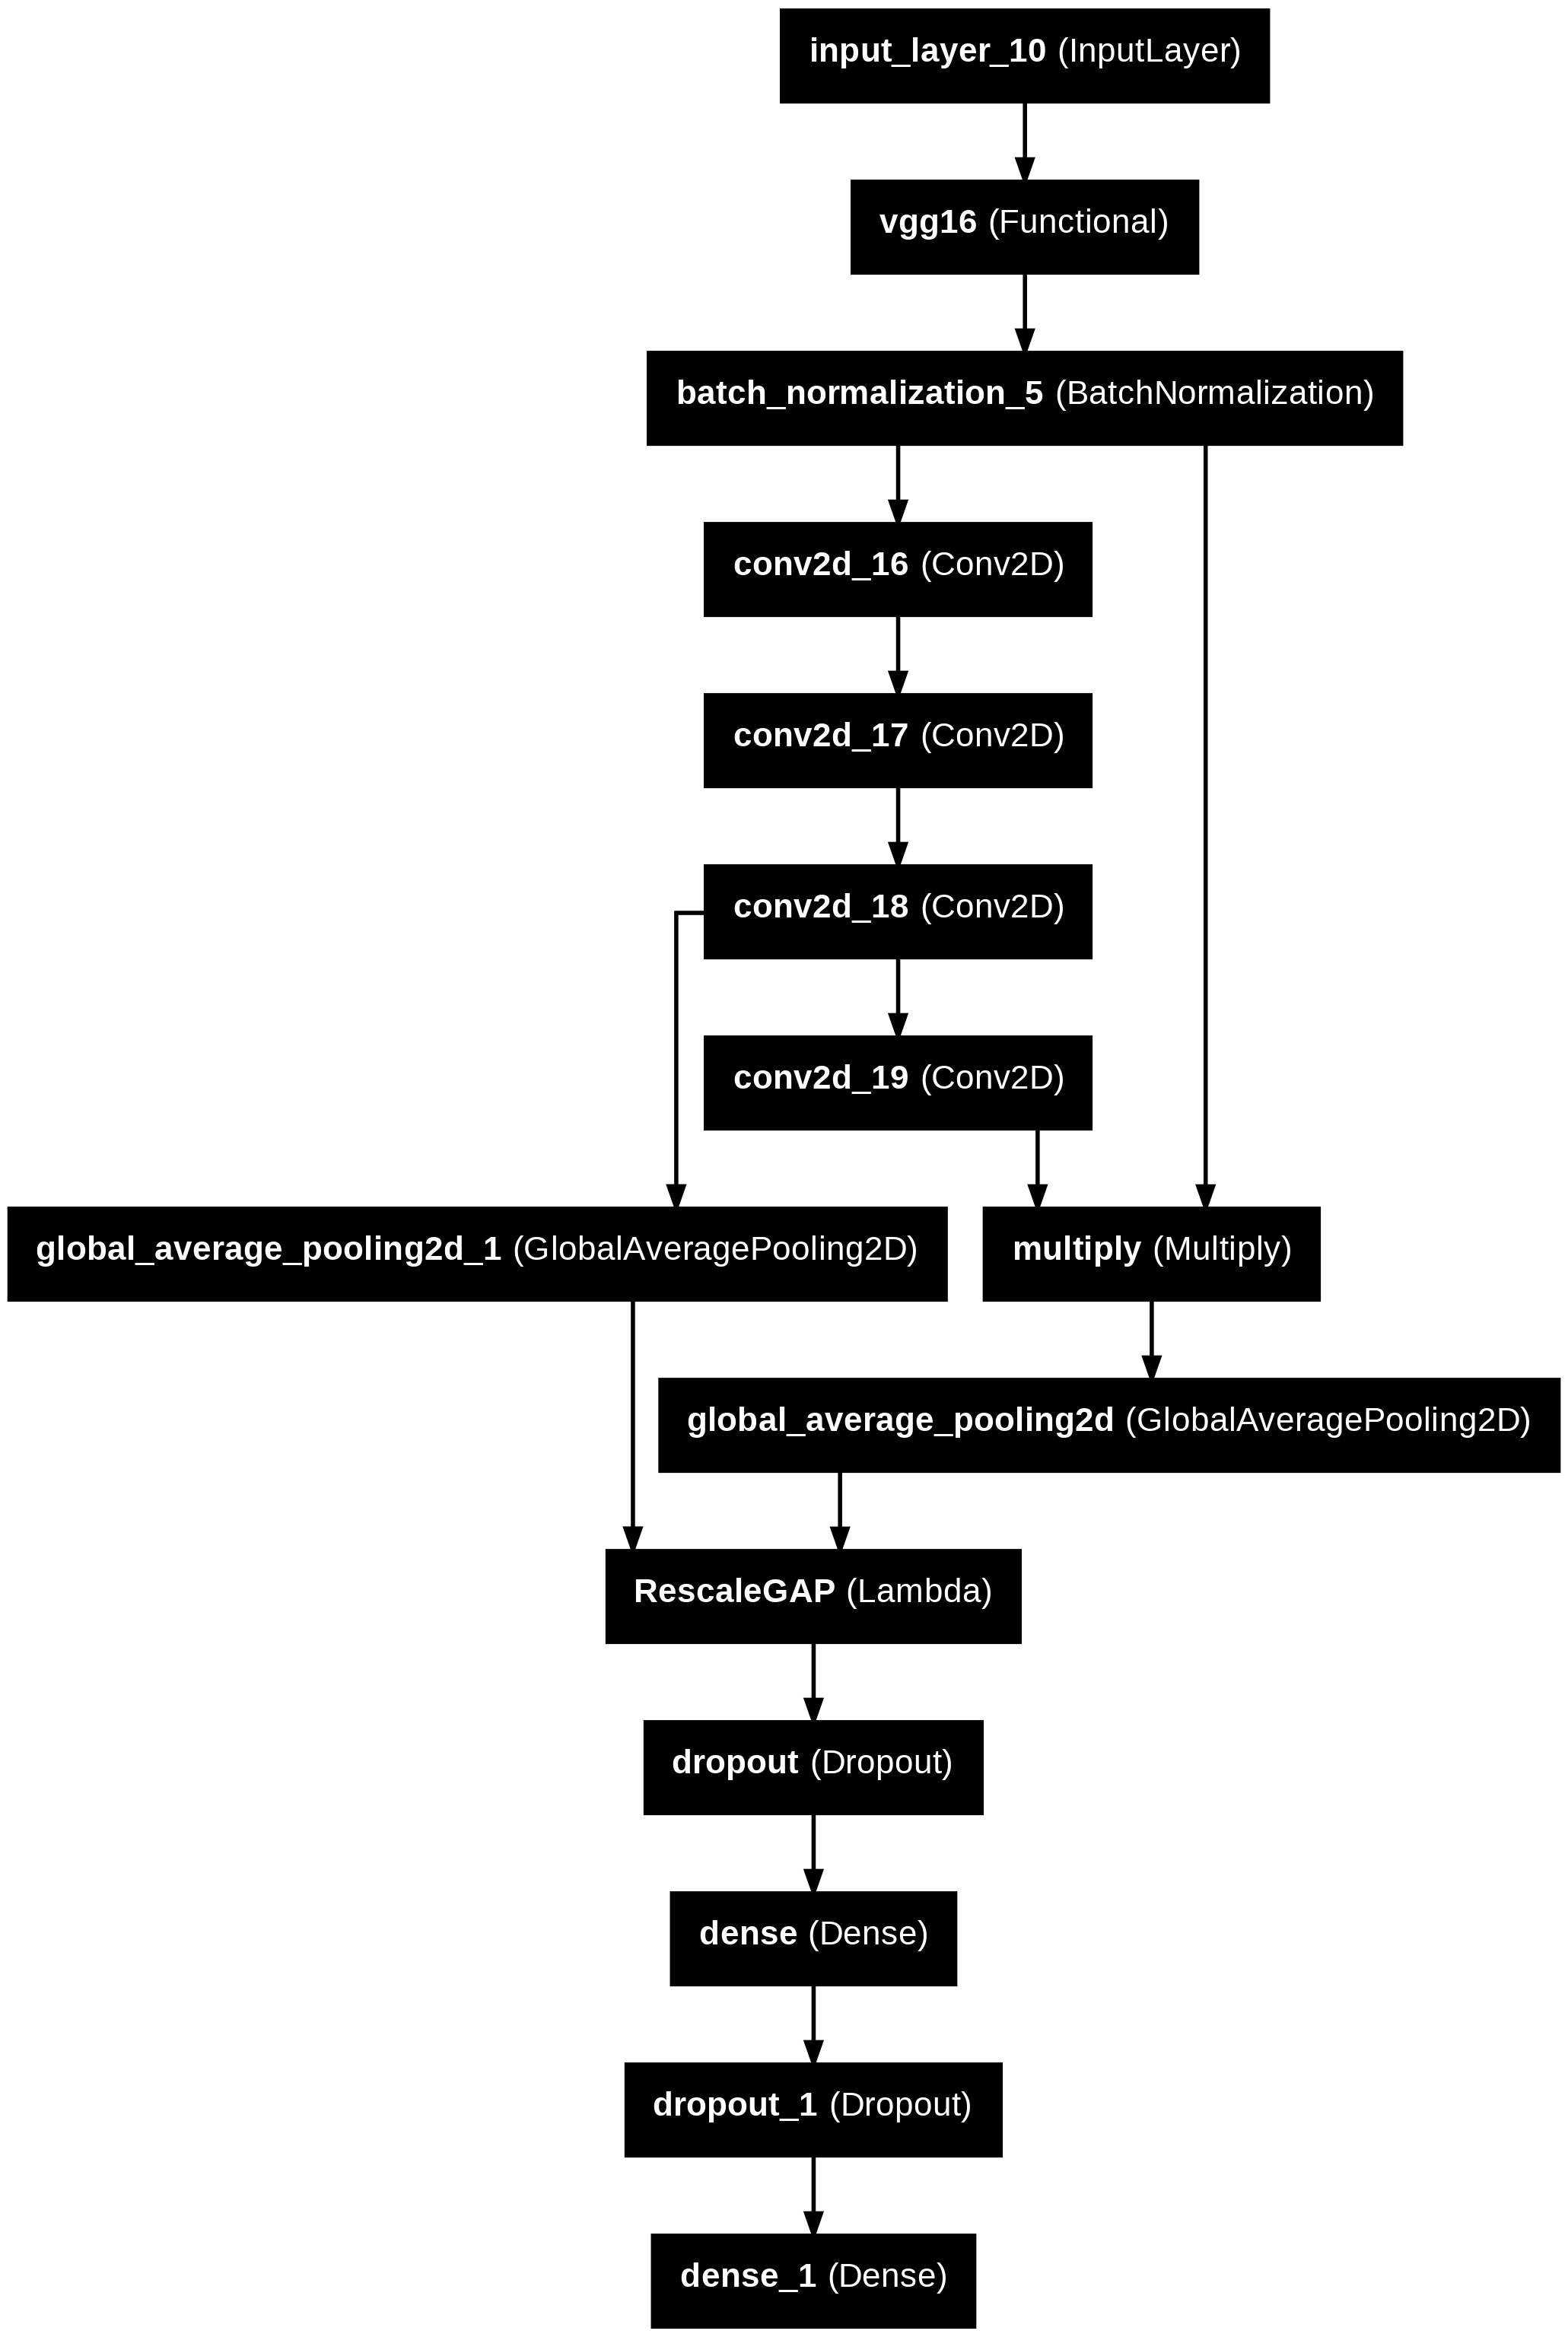

In [19]:
import tensorflow as tf
tf.keras.utils.plot_model(
    mammo_model,
    show_shapes=False,
    show_layer_names=True
)

In [25]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}.weights.h5".format('mammo_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
history = mammo_model.fit(X, Y,  validation_data = (X_test, y_test), 
                                  epochs = 50, 
                                  callbacks = callbacks_list)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - categorical_accuracy: 0.3790 - loss: 1.5588
Epoch 1: val_loss improved from inf to 1.50227, saving model to mammo_result.weights.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 406ms/step - categorical_accuracy: 0.3818 - loss: 1.5568 - val_categorical_accuracy: 0.3454 - val_loss: 1.5023 - learning_rate: 0.0010
Epoch 2/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_accuracy: 0.6039 - loss: 1.2082
Epoch 2: val_loss improved from 1.50227 to 1.34735, saving model to mammo_result.weights.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - categorical_accuracy: 0.6052 - loss: 1.2017 - val_categorical_accuracy: 0.4639 - val_loss: 1.3473 - learning_rate: 0.0010
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_accuracy: 0.6699 - loss: 0.8866
Epoch 3: val_loss improved from 1.34735 to 1.22285, saving model to mammo_result.weights.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - categorical_accuracy: 0.6703 - loss: 0.8848 - val_categorical_

In [26]:
# load the best version of the model
mammo_model.load_weights(weight_path)

# Show Attention
Did our attention model learn anything useful?

In [27]:
mammo_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 8, 8, 512)      │     14,714,688 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 8, 8, 512)      │          2,048 │ vgg16[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 8, 64)       │         32,832 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 8, 8, 16)       │          1,040 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 8, 8, 1)        │             17 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 8, 8, 512)      │            512 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 8, 8, 512)      │              0 │ conv2d_23[0][0],       │
│                           │                        │                │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ multiply_1[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1)              │              0 │ conv2d_22[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RescaleGAP (Lambda)       │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ RescaleGAP[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         65,664 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5)              │            645 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,020,916 (57.30 MB)

 Trainable params: 101,734 (397.40 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

 Optimizer params: 203,470 (794.81 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


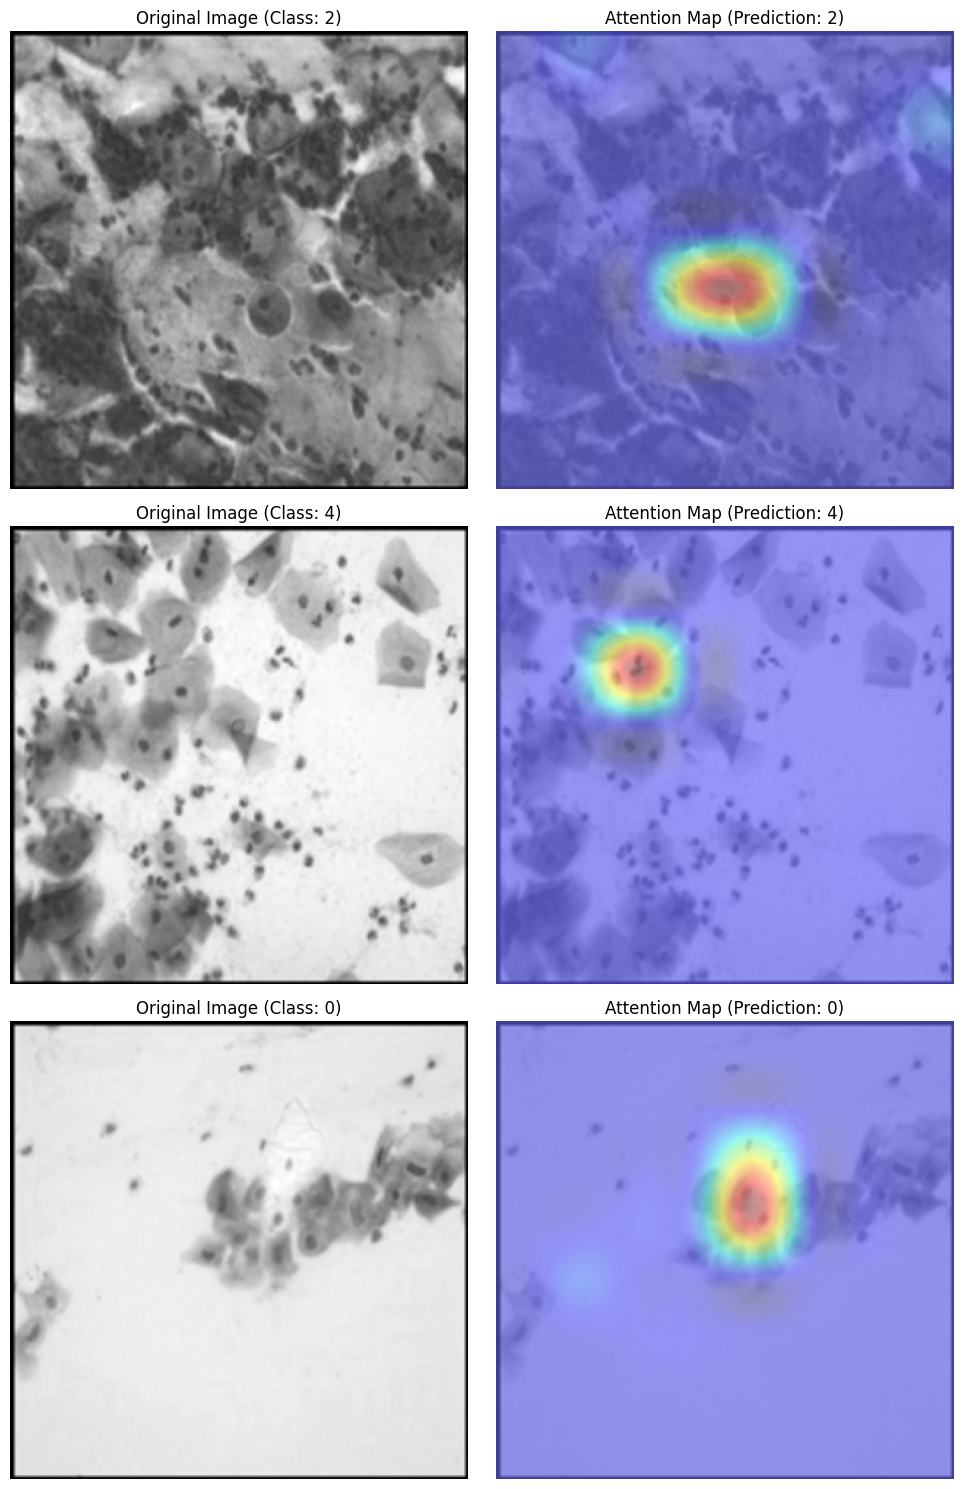

In [43]:
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Select 3 random images from X_test
num_images = 3
rand_idx = np.random.choice(range(len(X_test)), size=num_images, replace=False)
selected_images = X_test[rand_idx]

# Get the input tensor of the model
inputs = mammo_model.input  # Correct way
  # Use the input at node index 0

# Get the attention layer output
attention_layer_output = mammo_model.get_layer("conv2d_22").output  # Replace "conv2d_3" with the exact layer name

# Get the final predictions layer
predictions = mammo_model.get_layer('dense_3').output  # Replace "dense_2" with the exact layer name for predictions

# Create the new model
attention_model = Model(inputs=inputs, outputs=[predictions, attention_layer_output])


# Plot the attention maps
fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
for i, idx in enumerate(rand_idx):
    # Get the current image
    img = X_test[idx:idx + 1]

    # Get the prediction and attention map
    preds, attention_map = attention_model.predict(img)

    # Squeeze the attention map to remove extra dimensions
    attention_map = np.squeeze(attention_map)

    # Resize the attention map to match the original image size
    attention_map_resized = cv2.resize(
        attention_map, 
        (X_test.shape[2], X_test.shape[1]), 
        interpolation=cv2.INTER_CUBIC  # Higher quality resizing
    )

    # Normalize the attention map to range [0, 1]
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

    # Normalize the original image for better visualization
    img_normalized = (img[0, :, :, 0] - np.min(img[0, :, :, 0])) / (np.max(img[0, :, :, 0]) - np.min(img[0, :, :, 0]))

    # Plot the original image
    axs[i, 0].imshow(img_normalized, cmap='gray')  # Use grayscale for original image
    axs[i, 0].set_title(f"Original Image (Class: {y_test[idx]})")
    axs[i, 0].axis('off')

    # Plot the attention map overlay
    axs[i, 1].imshow(img_normalized, cmap='gray', alpha=0.6)  # Adjust alpha for better overlay
    axs[i, 1].imshow(attention_map_resized, cmap='jet', alpha=0.4)  # Use 'jet' colormap for attention map
    axs[i, 1].set_title(f"Attention Map (Prediction: {np.argmax(preds)})")
    axs[i, 1].axis('off')


# for i, idx in enumerate(rand_idx):
#     # Get the current image
#     img = X_test[idx:idx + 1]

#     # Get the prediction and attention map
#     preds, attention_map = attention_model.predict(img)

#     # Squeeze the attention map to remove extra dimensions
#     attention_map = np.squeeze(attention_map)

#     # Resize the attention map to match the original image size
#     attention_map_resized = cv2.resize(attention_map, (X_test.shape[2], X_test.shape[1]), interpolation=cv2.INTER_LINEAR)

#     # Normalize the attention map to range [0, 1]
#     attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

#     # Plot the original image
#     axs[i, 0].imshow(img[0, :, :, 0], cmap='bone')
#     axs[i, 0].set_title(f"Original Image (Class: {y_test[idx]})")
#     axs[i, 0].axis('off')

#     # Plot the attention map
#     axs[i, 1].imshow(img[0, :, :, 0], cmap='bone', alpha=0.5)  # Overlay the original image
#     axs[i, 1].imshow(attention_map_resized, cmap='bone', alpha=0.5)  # Overlay the attention map
#     axs[i, 1].set_title(f"Attention Map (Prediction: {np.argmax(preds)})")
#     axs[i, 1].axis('off')

# Adjust spacing and save the figure
plt.tight_layout()
plt.savefig("attention_maps.png", dpi=300)
plt.show()


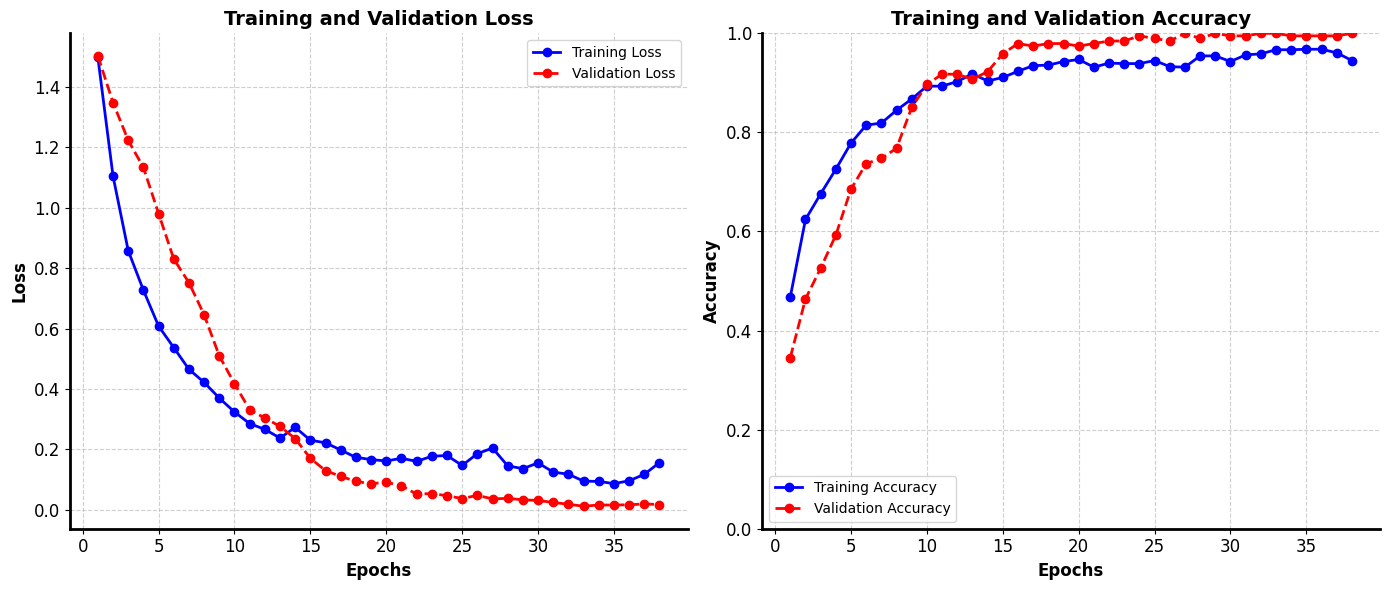

In [29]:
# Extract training history data
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Create a figure with 2 subplots: one for loss and one for accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Loss
axs[0].plot(epochs_range, loss, label='Training Loss', color='b', marker='o', linestyle='-', linewidth=2)
axs[0].plot(epochs_range, val_loss, label='Validation Loss', color='r', marker='o', linestyle='--', linewidth=2)
axs[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plotting Accuracy
axs[1].plot(epochs_range, acc, label='Training Accuracy', color='b', marker='o', linestyle='-', linewidth=2)
axs[1].plot(epochs_range, val_acc, label='Validation Accuracy', color='r', marker='o', linestyle='--', linewidth=2)
axs[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

# Make sure to bold the ticks and gridlines
for ax in axs:
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('training_loss_accuracy.png', dpi=300)
plt.show()

# Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

In [30]:
pred_Y = mammo_model.predict(X_test, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
y_test = np.argmax(y_test,-1)
test_Y_cat = y_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


In [31]:
print("Unique classes in test_Y_cat:", len(np.unique(test_Y_cat)))
print("Unique classes in pred_Y_cat:", len(np.unique(pred_Y_cat)))


Unique classes in test_Y_cat: 5
Unique classes in pred_Y_cat: 5


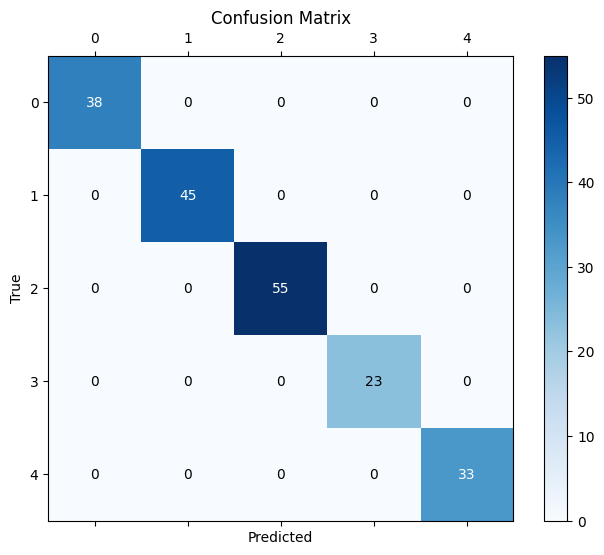

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        33

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Differences between averaging methods:
- Micro Average: Calculates metrics globally by counting the total true positives, false negatives, and false positives. It is useful when you want to evaluate the overall performance.
- Macro Average: Calculates metrics for each class separately and then takes the average. It treats all classes equally and is useful when you want to give equal weight to all classes.
- Weighted Average: Similar to macro average, but it takes the 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, cohen_kappa_score

# Assuming test_Y_cat and pred_Y_cat are your true labels and predictions
labels = np.unique(test_Y_cat)

# Compute confusion matrix
cm = confusion_matrix(test_Y_cat, pred_Y_cat)

# Plot confusion matrix with numbers
plt.figure(figsize=(8, 6))
plt.matshow(cm, cmap='Blues', fignum=1)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add numbers to confusion matrix
for (i, j), value in np.ndenumerate(cm):
    plt.text(j, i, f'{value}', ha='center', va='center', color='white' if value > cm.max()/2 else 'black')

plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.show()

# Print classification report
print(classification_report(test_Y_cat, pred_Y_cat, labels=labels))

# Function to calculate additional metrics
def calculate_metrics(test_y, pred_y):
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    specificity_dict = {}
    sensitivity_dict = {}
    
    for avg in ['micro', 'macro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(test_y, pred_y, average=avg)
        
        # Calculate specificity and sensitivity for each class
        for label in np.unique(test_y):
            TN = cm.sum() - (cm[:, label].sum() + cm[label, :].sum() - cm[label, label])
            FP = cm[:, label].sum() - cm[label, label]
            TP = cm[label, label]
            FN = cm[label, :].sum() - cm[label, label]
            
            specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
            sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
            
            specificity_dict[label] = specificity
            sensitivity_dict[label] = sensitivity

        # Store metrics in dictionaries
        precision_dict[avg] = precision
        recall_dict[avg] = recall
        f1_dict[avg] = f1

    return precision_dict, recall_dict, f1_dict, specificity_dict, sensitivity_dict

# Get predicted probabilities
pred_probs = mammo_model.predict(X_test)  # Make sure to replace 'model' with your actual model variable

# Calculate metrics
precision_dict, recall_dict, f1_dict, specificity_dict, sensitivity_dict = calculate_metrics(test_Y_cat, pred_Y_cat)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Micro': [
        precision_dict['micro'], 
        recall_dict['micro'], 
        f1_dict['micro']
    ],
    'Macro': [
        precision_dict['macro'], 
        recall_dict['macro'], 
        f1_dict['macro']
    ],
    'Weighted': [
        precision_dict['weighted'], 
        recall_dict['weighted'], 
        f1_dict['weighted']
        
    ]
})

# Calculate specificity and sensitivity for each label
for label in np.unique(test_Y_cat):
    summary_df.loc[summary_df['Metric'] == 'Specificity', 'Micro'] = specificity_dict[label] if 'micro' in specificity_dict else np.nan
    summary_df.loc[summary_df['Metric'] == 'Sensitivity', 'Micro'] = sensitivity_dict[label] if 'micro' in sensitivity_dict else np.nan



# Explanation of averaging methods
print("\nDifferences between averaging methods:")
print("- Micro Average: Calculates metrics globally by counting the total true positives, false negatives, and false positives. It is useful when you want to evaluate the overall performance.")
print("- Macro Average: Calculates metrics for each class separately and then takes the average. It treats all classes equally and is useful when you want to give equal weight to all classes.")
print("- Weighted Average: Similar to macro average, but it takes the class imbalance into account by weighing the metrics of each class by its size. It is useful when you want to balance performance across classes.")


In [33]:
summary_df

,Metric,Micro,Macro,Weighted
0,Precision,1.0,1.0,1.0
1,Recall,1.0,1.0,1.0
2,F1 Score,1.0,1.0,1.0


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
                          precision    recall  f1-score   support

            Dyskeratotic     0.9955    0.9955    0.9955       223
            Koilocytotic     0.9916    0.9958    0.9937       238
             Metaplastic     1.0000    1.0000    1.0000       271
               Parabasal     1.0000    1.0000    1.0000       108
Superficial-Intermediate     1.0000    0.9921    0.9960       126

                accuracy                         0.9969       966
               macro avg     0.9974    0.9967    0.9970       966
            weighted avg     0.9969    0.9969    0.9969       966




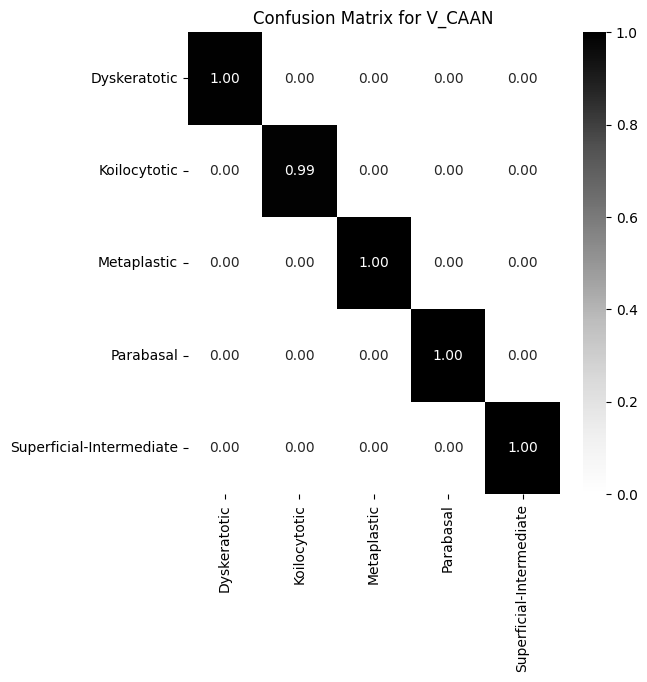

,Model,Accuracy,Cohen's Kappa,Jaccard Similarity,Dyskeratotic_Precision,Dyskeratotic_Recall,Dyskeratotic_F1-Score,Koilocytotic_Precision,Koilocytotic_Recall,Koilocytotic_F1-Score,Metaplastic_Precision,Metaplastic_Recall,Metaplastic_F1-Score,Parabasal_Precision,Parabasal_Recall,Parabasal_F1-Score,Superficial-Intermediate_Precision,Superficial-Intermediate_Recall,Superficial-Intermediate_F1-Score
0,V_CAAN,0.996894,0.996007,0.994127,0.995516,0.995516,0.995516,0.991632,0.995798,0.993711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.992063,0.996016


In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Global DataFrame to store results (shared with machine learning models)
crdf = pd.DataFrame()

def visualise(y_true, y_pred, name, model_name):
    ConfusionM = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    print(classification_report(y_true, y_pred, target_names=name, digits=4))
    print()

    # Plot confusion matrix heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(ConfusionM / ConfusionM.astype(float).sum(axis=0),
                annot=True, fmt='0.2f', cmap='Greys', 
                xticklabels=name, yticklabels=name)
    plt.title('Confusion Matrix for ' + model_name)
    plt.savefig('CM_' + model_name + '.jpg')
    plt.show()

    # Calculate various metrics
    accuracy = accuracy_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)
    jaccard_sim = jaccard_score(y_true, y_pred, average='macro')

    # Append results to global DataFrame
    global crdf
    temp_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Cohen\'s Kappa': [cohen_kappa],
        'Jaccard Similarity': [jaccard_sim]
    })

    # Append classification metrics for each class (Precision, Recall, F1-Score)
    report = classification_report(y_true, y_pred, target_names=name, output_dict=True)
    for label in name:
        temp_df[f'{label}_Precision'] = report[label]['precision']
        temp_df[f'{label}_Recall'] = report[label]['recall']
        temp_df[f'{label}_F1-Score'] = report[label]['f1-score']

    crdf = pd.concat([crdf, temp_df], ignore_index=True)

# Example prediction function for deep learning model
def pred(X, Y):
    yhat = mammo_model.predict(X)
    yhat = enc.inverse_transform(yhat)
    y_real = enc.inverse_transform(Y)
    return y_real, yhat

# Example usage for the deep learning model
yt, yp = pred(X, Y)  # Replace 'xop' and 'Y' with your actual test data and labels

visualise(yt, yp, list(classes) , 'V_CAAN')  # 'ANN' for Artificial Neural Network or any other model name

# The `crdf` DataFrame will now include results from both ML and DL models.
crdf